# Config env

In [1]:
!pip install rfdetr supervision roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706

In [2]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Prepare data

In [4]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/augmented-startups/vehicle-registration-plates-trudk/dataset/1", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle-Registration-Plates-1 in coco:: 100%|██████████| 8831/8831 [00:03<00:00, 2727.34it/s]


# Load detr model


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !cp -r /content/drive/MyDrive/car_plates_recognition/finetuning/rf-detr_nano_3 .

In [7]:
from rfdetr import RFDETRNano
model = RFDETRNano(pretrain_weights="/content/rf-detr_nano_3/checkpoint_best_total.pth")
model.optimize_for_inference() # some kind of error here

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


# Annotate image

In [8]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

In [71]:
from PIL import Image

path = ds[1][0]
test_image = Image.open(path)

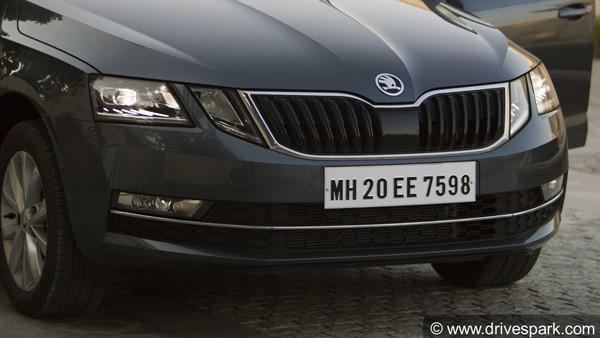

In [72]:
test_image

In [73]:
detections = model.predict(test_image)

In [74]:
detections

Detections(xyxy=array([[321.81625, 160.75307, 478.13712, 208.37704]], dtype=float32), mask=None, confidence=array([0.888312], dtype=float32), class_id=array([1]), tracker_id=None, data={}, metadata={})

In [75]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()


labels = [
    f"Plate: {confidence:.2f}"
    for class_name, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = box_annotator.annotate(
    scene=test_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)

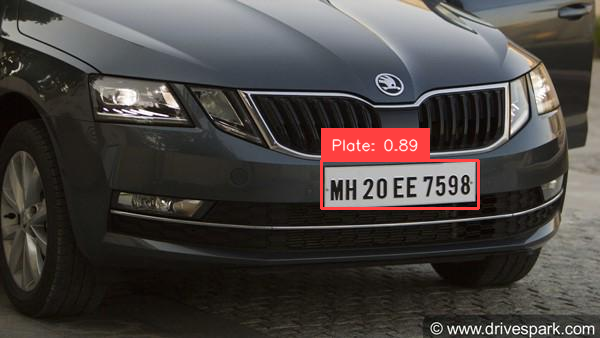

In [76]:
annotated_image

# Cut only plate img

In [86]:
detections.xyxy

array([[321.81625, 160.75307, 478.13712, 208.37704]], dtype=float32)

In [90]:
box = detections.xyxy[0]
x1, y1, x2, y2 = box.astype(int)

crop = test_image.crop((x1, y1, x2, y2))

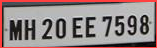

In [91]:
crop

# OCR on plate image